### Import libraries and mwlmc model

- Lilleengen+23 paper - https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..774L/abstract)
- mwlmc github repo - https://github.com/sophialilleengen/mwlmc
- Dependencies: numpy, astropy, yaml, gala, matplotlib

In [2]:
import numpy as np
import astropy.units as u
import yaml
import gala.integrate as gi, gala.dynamics as gd, gala.potential as gp
import matplotlib, matplotlib.pyplot as plt
import os, os.path
from gala.units import galactic

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


### Functions for orbit integration

In [3]:
def gala_F_inertial(t, w, mwdflag, mwhflag, lmcflag):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
    # acc_disk = MiyamotoNagai.acceleration(w[:3, :] - x0[:3, None]).to((u.km**2/(u.s**2*u.kpc))).value
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))

def gala_rewind_inertial(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_inertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [4]:
def gala_rewind_inertial_novelcor(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_inertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) * 0
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [5]:
def gala_F_noninertial(t, w, mwdflag, mwhflag, lmcflag):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    accs = Model.all_forces(t, *(w[:3, :]), mwhflag, mwdflag, lmcflag) * (u.km**2/(u.s**2*u.kpc))
    
    accs = (accs).decompose(galactic).value
    return np.vstack((w[3:], accs.T))

def gala_rewind_noninertial(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag):
    
    integrator = gi.LeapfrogIntegrator(gala_F_noninertial, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
 
    w0 = gd.PhaseSpacePosition(pos=w.xyz ,
                               vel=(w.v_xyz.to(u.km/u.s)).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)

    pos=orbit.xyz 
    vel=orbit.v_xyz.to(u.km/u.s) 
    t=orbit.t
    return pos.to(u.kpc), vel.to(u.km/u.s), t.to(u.Gyr)

In [6]:
def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    Tbegin = d["Tbegin"]
    Tfinal =  d["Tfinal"]
    dtmin  = 0.002 #d["dtmin"]
    haloflag = d["haloflag"]
    lmcflag = d["lmcflag"]
    discflag = d["discflag"]

    return [prog_ics, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag ]

In [7]:
file = "../ics/full-mwh-full-mwd-full-lmc/param_0.yaml"
# file = "../ics/param-files/gd1/static-mw.yaml"
params = readparams(file)
fc, Tbegin, Tfinal, dtmin, haloflag, discflag, lmcflag  = params

w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)

In [8]:


prog_orbit_inertial = gala_rewind_inertial(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)

prog_orbit_inertial_novelcorr = gala_rewind_inertial_novelcor(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)

prog_orbit_noninertial = gala_rewind_noninertial(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, discflag, haloflag, lmcflag)


Text(0, 0.5, '$\\mathbf{v}_{\\mathrm{prog}}\\,[\\mathrm{km}\\,\\mathrm{s}^{-1}]$')

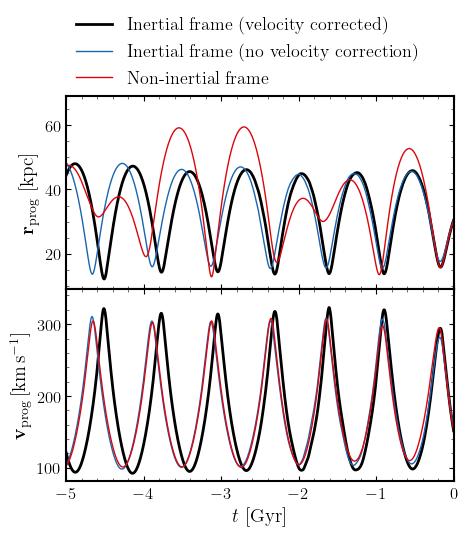

In [9]:
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex='col')
plt.subplots_adjust(hspace=0.0)

plt.sca(ax[0])
plt.plot(prog_orbit_inertial[2], np.linalg.norm(prog_orbit_inertial[0].T,axis=1).value, 
         label='Inertial frame (velocity corrected)', c='k', lw=2)
plt.plot(prog_orbit_inertial_novelcorr[2], np.linalg.norm(prog_orbit_inertial_novelcorr[0].T,axis=1).value, 
         label='Inertial frame (no velocity correction)', c='#1965B0', lw=1)
plt.plot(prog_orbit_noninertial[2], np.linalg.norm(prog_orbit_noninertial[0].T,axis=1).value, 
         label='Non-inertial frame', c='#DC050C', lw=1)
plt.xlim(-5.0,0.0)
plt.ylim(9,69)

plt.legend(ncol=1, frameon=False, fontsize=13,  bbox_to_anchor=(.95, 1.5))
plt.ylabel('$\mathbf{r}_{\mathrm{prog}}$ [kpc]', fontsize=14)

plt.sca(ax[1])
plt.plot(prog_orbit_inertial[2], np.linalg.norm(prog_orbit_inertial[1].T,axis=1).value, c='k', lw=2 )
plt.plot(prog_orbit_inertial_novelcorr[2], np.linalg.norm(prog_orbit_inertial_novelcorr[1].T,axis=1).value, c='#1965B0', lw=1 )
plt.plot(prog_orbit_noninertial[2], np.linalg.norm(prog_orbit_noninertial[1].T,axis=1).value, c='#DC050C', lw=1)
plt.ylim(81, 349)

plt.xlabel('$t$ [Gyr]', fontsize=14)
plt.ylabel('$\mathbf{v}_{\mathrm{prog}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)

# plt.savefig('figures/paper-figs/fig7')